In [40]:
import numpy as np
import matplotlib.pyplot as plt
from TDOA_estimation import apply_fir_filter, GCC_PHAT, CrossCorr, EllipticFilter
import time
from scipy.signal import filtfilt,ellip, freqz
import matplotlib.pyplot as plt

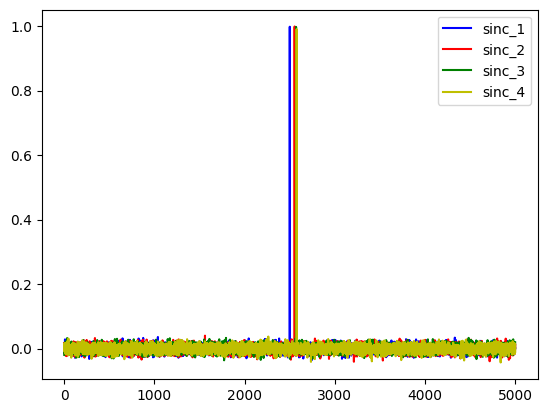

In [41]:
addNoise = True

fs = 100000  # Sampling frequency in Hz

length = 5000  # Length of the signal
frequency = 40000  # Frequency of the sinc functions

offset2 = 54  # Offset between the sinc functions
offset3 = 70  # Offset between the sinc functions
offset4 = 76  # Offset between the sinc functions


x = np.linspace(-length / 2, length / 2, length, endpoint=False)
signal_1 = np.sinc(frequency * x)
signal_2 = np.sinc(frequency * (x - offset2))  # Apply phase shift to the second sinc function
signal_3 = np.sinc(frequency * (x - offset3))
signal_4 = np.sinc(frequency * (x - offset4))  # Apply phase shift to the second sinc function

trueTDOAs = np.array([[0,0,0,0],[ - offset2,  0,  0,  0],[- offset3, -(offset3 - offset2),  0,  0],[-offset4, - (offset4 - offset2), -(offset4 - offset3),  0]]) / fs


noiseScale = .01
if addNoise:
    signal_1 = signal_1 + np.random.normal(scale=noiseScale, size=len(signal_1))
    signal_2 = signal_2 + np.random.normal(scale=noiseScale, size=len(signal_1))
    signal_3 = signal_3 + np.random.normal(scale=noiseScale, size=len(signal_1))
    signal_4 = signal_4 + np.random.normal(scale=noiseScale, size=len(signal_1))

plt.plot(signal_1,c= 'b', label = "sinc_1")
plt.plot(signal_2, c= 'r', label = "sinc_2")
plt.plot(signal_3,c= 'g', label = "sinc_3")
plt.plot(signal_4, c= 'y', label = "sinc_4")
plt.legend()
plt.show()

## Test FIR filter

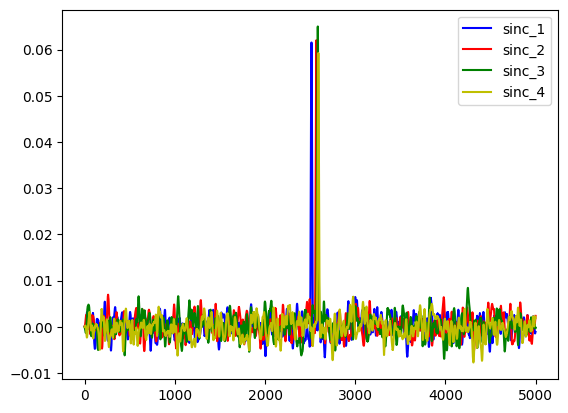

TDOA using cross-correlation: 
[[ 0.0e+00  0.0e+00  0.0e+00  0.0e+00]
 [-5.5e-04  0.0e+00  0.0e+00  0.0e+00]
 [-7.0e-04 -1.5e-04  0.0e+00  0.0e+00]
 [-7.6e-04 -2.1e-04 -6.0e-05  0.0e+00]]
Runtime:  0.0678701400756836
Error: 
1.7320508075688804e-05
TDOA using GCC-PHAT: 
[[ 0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00]
 [-8.50625e-04  0.00000e+00  0.00000e+00  0.00000e+00]
 [-1.01000e-03 -1.60000e-04  0.00000e+00  0.00000e+00]
 [-7.74375e-04  9.06250e-05 -6.00000e-05  0.00000e+00]]
Runtime:  0.008778095245361328
Error: 
0.0005378498134935068
Rune time test: 
9.85400676727295e-05


In [42]:

filterStartTime = time.time()
cutoff_freq_hz = 30000  # Cutoff frequency for highpass filter
num_taps = 31  # Number of taps for the FIR filter
signal_1_fir = apply_fir_filter(signal_1, cutoff_freq_hz, num_taps, fs)
signal_2_fir = apply_fir_filter(signal_2, cutoff_freq_hz, num_taps, fs)
signal_3_fir = apply_fir_filter(signal_3, cutoff_freq_hz, num_taps, fs)
signal_4_fir = apply_fir_filter(signal_4, cutoff_freq_hz, num_taps, fs)


plt.plot(signal_1_fir,c= 'b', label = "sinc_1")
plt.plot(signal_2_fir, c= 'r', label = "sinc_2")
plt.plot(signal_3_fir,c= 'g', label = "sinc_3")
plt.plot(signal_4_fir, c= 'y', label = "sinc_4")
plt.legend()
plt.show()

dataMatrix = np.vstack(np.array([signal_1_fir, signal_2_fir,signal_3_fir, signal_4_fir]))


# Calculate TDOA using cross-correlation
startTime = time.time()
tdoa_cross_corr = CrossCorr(dataMatrix, fs)
print("TDOA using cross-correlation: ")
print(tdoa_cross_corr)
print("Runtime: ", time.time() - startTime)
print("Error: ")
print(np.sqrt(np.sum((tdoa_cross_corr - trueTDOAs)**2)))


NewstartTime = time.time()
offset = GCC_PHAT(dataMatrix, fs,max_tau=None, interp=16)
print("TDOA using GCC-PHAT: ")
print(offset)
print("Runtime: ", time.time() - NewstartTime)
print("Error: ")
print(np.sqrt(np.sum((offset - trueTDOAs)**2)))


print("Rune time test: ")
filterStartTime = time.time()
N = 1000
for i in range(N):
    xxx = apply_fir_filter(signal_1, cutoff_freq_hz, num_taps, fs)
runTime = time.time() - filterStartTime
print(runTime / N)

## Elliptic Filter test

b coefficients: [ 0.49580191 -1.9260157   2.8613285  -1.9260157   0.49580191]
a coefficients: [ 1.         -2.53934052  2.67821627 -1.31270499  0.26392123]


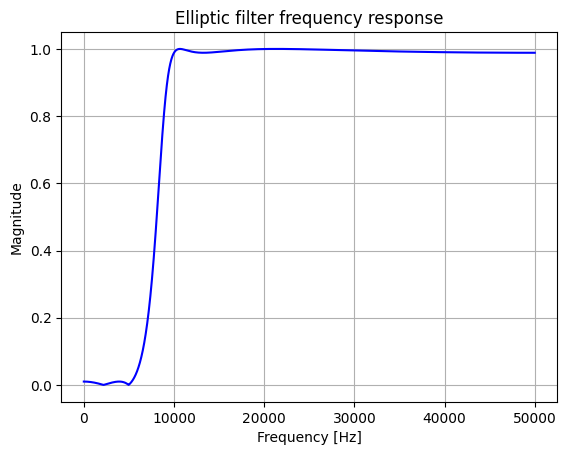

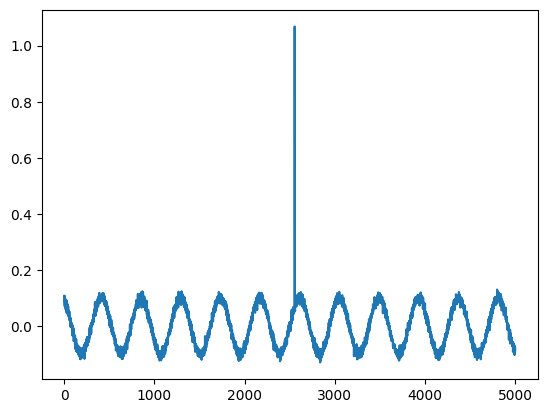

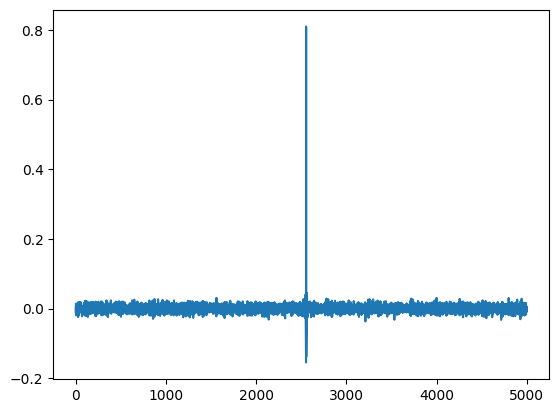

Rune time test: 
0.0001125040054321289


In [52]:
order = 4
ripple_db = 0.1
cutoff_freq = 10000
sample_rate = 100000

b, a = EllipticFilter(order, ripple_db, cutoff_freq, sample_rate)
# Print coefficients
print("b coefficients:", b)
print("a coefficients:", a)

# Frequency response
w, h = freqz(b, a, worN=8000)
plt.figure()
plt.plot(0.5*sample_rate*w/np.pi, np.abs(h), 'b')
plt.title("Elliptic filter frequency response")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

newSig = signal_2 + .1*np.sin(x/70)
plt.plot(newSig)
plt.show()
filtered_signal = filtfilt(b, a, newSig)
plt.plot(filtered_signal)
plt.show()

print("Rune time test: ")
filterStartTime = time.time()
N = 1000
for i in range(N):
    xxx = filtfilt(b, a, newSig)
runTime = time.time() - filterStartTime
print(runTime / N)